# Classification model with Keras Tuner: LSE vowels

**Source:** [Image classification using Keras Tuner](https://keras.io/guides/keras_tuner/getting_started/)<br>
**Author:** Vanessa Alvear <br>
**Date created:** 2023/04/05<br>
**Last modified:** 2023/04/25<br>
**Description:** Training an image classifier from scratch using a hyperparameter search for the vowels from the Spanish Sign Language (Lengua de Signos Española -  LSE ).

## Introduction

This guide trains a neural network model to classify images of the vowels of the Spanish Sign Language (Lengua de Signos Española - LSE) using the [Keras Tuner](https://www.tensorflow.org/guide/keras) for searching hyperparameters.

This notebook shows how to do image classification from scratch of the vowels of the LSE, 
starting from JPG image files load it from the dataset vowelsLSE. This code is based on the workflow on Getting started with KerasTuner in the official documentation. We use the `image_dataset_from_directory` utility to generate the datasets.

In the next figure, we can see the signs of the vowels from LSE.

In [1]:
from PIL import Image

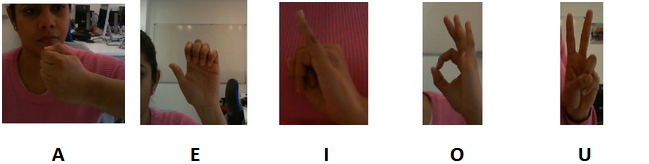

In [2]:
Image.open("vowels_lse_dataset_sample.png")

## Libraries

We define the GPU to be used

In [3]:
%env CUDA_VISIBLE_DEVICES = 2

env: CUDA_VISIBLE_DEVICES=2


In [4]:
import tensorflow as tf

2023-04-27 17:41:41.426971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 17:41:41.560296: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
print(tf.__version__)

2.10.0


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
import os
import numpy as np
import pandas as pd

In [7]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers, losses

In [8]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K

In [9]:
seed = 1234

In [10]:
import cv2

## Dataset: vowelsLSE

It was created on March, 2023 in the Universidad de La Rioja. It consists of RGB images of 5 different gestures in JPG format. It contains three folders, one for training `train` (4376 images), one for testing `test` (1215 images), one for validation (487 images) for a total of 6078 images. It contains 5 classes. The images can be classified into: 
  - A (600 (right hand) 615 (left hand), total images: 1215)
  - E (600 (right hand) 619 (left hand), total images: 1219)
  - I (601 (right hand) 611 (left hand), total images: 1212)
  - O (601 (right hand) 619 (left hand), total images: 1220)
  - U (612 (right hand) 600 (left hand), total images: 1212)
  
The images are 300 x 300 in size and have a white background so that they are the same size.

The data is loaded as a folder with .zip extension. Unzip the data

In [ ]:
#!unzip dataset_vocales_All.zip 

Now we have three folders `train, test, valid` which contains five subfolders, `A, E, I, O`,  and `U`. Each subfolder has image files for each category.

In [ ]:
!ls train

/bin/bash: /opt/anaconda/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
A  E  I  O  U


In [ ]:
!ls valid

/bin/bash: /opt/anaconda/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
A  E  I  O  U


In [ ]:
!ls test 

/bin/bash: /opt/anaconda/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
A  E  I  O  U


We can see how many data is in each subfolder

In [ ]:
class_names = ['A', 'E', 'I', 'O', 'U']

In [ ]:
def countFilesPath(path, classNames, path_name):
    for i in classNames:
        print("Number of files "+ path_name + str(i) +" =", len([entry for entry in os.listdir(path+'/'+ str(i)) if os.path.isfile(os.path.join(path+'/'+ str(i), entry))]))

In [11]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

In [ ]:
countFilesPath(train_path, class_names, "train_path_")

Number of files train_path_A = 875
Number of files train_path_E = 877
Number of files train_path_I = 873
Number of files train_path_O = 878
Number of files train_path_U = 873


In [ ]:
countFilesPath(valid_path, class_names, "valid_path_")

Number of files valid_path_A = 97
Number of files valid_path_E = 98
Number of files valid_path_I = 97
Number of files valid_path_O = 98
Number of files valid_path_U = 97


In [ ]:
countFilesPath(test_path, class_names, "test_path_")

Number of files test_path_A = 243
Number of files test_path_E = 244
Number of files test_path_I = 242
Number of files test_path_O = 244
Number of files test_path_U = 242


## Data preprocess

For a total of 6078 images

### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [ ]:
def findCorruptedImages(path, classes):
    num_skipped = 0
    for folder_name in classes:
        folder_path = os.path.join(path, folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(fpath)

    print("Deleted %d images" % num_skipped)
    

In [ ]:
findCorruptedImages(train_path, class_names)

IsADirectoryError: [Errno 21] Is a directory: 'train/A/.ipynb_checkpoints'

In [ ]:
findCorruptedImages(valid_path, class_names)

Deleted 0 images


In [ ]:
findCorruptedImages(test_path, class_names)

Deleted 0 images


In [ ]:
rm -rf train/A/.ipynb_checkpoints

/bin/bash: /opt/anaconda/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
findCorruptedImages(train_path, class_names)

Deleted 0 images


## Generate a `Dataset`

Every image size is `300 x 300`. Besides we create a *train dataset* and a *validation dataset* with batch size of 64.

## Keras Tuner for LSE vowels classification

In [ ]:
#!unzip valid_data_with_subfolders.zip 

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = (300, 300)

In [ ]:
train_data = keras.utils.image_dataset_from_directory(
                  directory="train", # path to load data
                  labels= 'inferred', # to load the labels based on the folder’s name
                  label_mode='categorical', # labels are loaded as one-hot vectors
                  color_mode='rgb',
                  batch_size=BATCH_SIZE,
                  seed=seed,
                  shuffle=True,
                  image_size= IMAGE_SIZE )

Found 4376 files belonging to 5 classes.


2023-04-24 13:32:44.832065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9639 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5


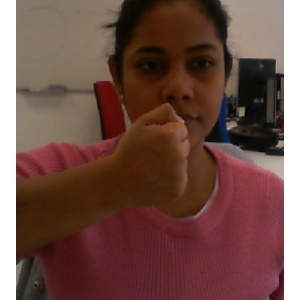

In [ ]:
PIL.Image.open("a_train.jpg")

In [ ]:
val_data = keras.utils.image_dataset_from_directory(
                  directory="valid", # path to load data
                  labels= 'inferred', # to load the labels based on the folder’s name
                  label_mode='categorical', # labels are loaded as one-hot vectors
                  color_mode='rgb',
                  batch_size=BATCH_SIZE,
                  seed=seed,
                  shuffle=True,
                  image_size=IMAGE_SIZE )

Found 487 files belonging to 5 classes.


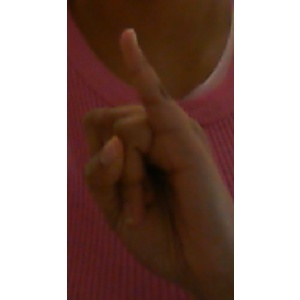

In [ ]:
PIL.Image.open("i_valid.jpg")

In [ ]:
test_data = keras.utils.image_dataset_from_directory(
                  directory="test", # path to load data
                  labels= 'inferred', # to load the labels based on the folder’s name
                  label_mode='categorical', # labels are loaded as one-hot vectors
                  color_mode='rgb',
                  batch_size=BATCH_SIZE,
                  seed=seed,
                  shuffle=True,
                  image_size=IMAGE_SIZE )

Found 1215 files belonging to 5 classes.


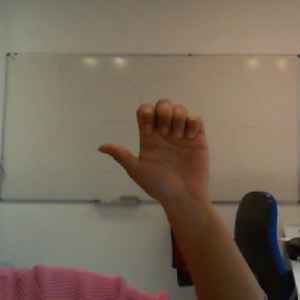

In [ ]:
PIL.Image.open("e_test.jpg")

## Basics of Keras Tuner

Before we move into the more complicated code, we need to understand the workflow of Keras-Tuner.

1. We define a `build()` function that takes an argument **hp** (`keras_tuner.Hyperparameter` object). Inside, we define our model architecture and the hyperparameter search space.
2. In order to define a search space, **hp** object offers 4 methods. `hp.Choice(), hp.Int(), hp.Float() and hp.Boolean()`. The hp.Choice() method is the most general and accepts a list of str, int, float or boolean values, but all must have the same type. The other methods are self-explainable. Here are some intuitive examples

```python
def MyHyperModel(hp):
  # defining the number of neurons in a fully connected layer
  units = hp.Choice(name="neurons", values=[150, 200])
  # defining the number of neurons dynamically with the hp.Int method
  units = 5 #hp.Int(name="neurons", min=100, max=200, step=10)
  # defining the dropout rate
  dropout = hp.Int(name="dropout", min=0.0, max=0.3, step=0.05)
  # Automatically assign True/False values.
  shuffle = hp.Boolean("shuffle", default=False)

  return model
```



3. Initialize a tuner that is responsible for searching the hyperparameter space. Keras-Tuner offers 3 different search strategies, RandomSearch, Bayesian Optimization, and HyperBand. For all tuners, we need to specify a HyperModel, a metric to optimize, a computational budget, and optionally a directory to save results. For more details regarding the arguments each tuner accepts, feel free to check the relevant [documentation](https://keras.io/api/keras_tuner/tuners/). Below is an example of a HyperBand tuner.

Beware, however, as the possible combinations might become extremely large, and a lot of computational power will be needed.

Specifying the tunable variable’s name with `name=f”kernel_{i}”` inside a loop allows you to define a different search space for each parameter on every layer.

One limitation of the Keras tuner is that it doesn’t accept variables other than `int, float, str, or boolean`. Hence, we cannot pass `keras.optimizer` objects in the choice method. 

This limits our hyperparameter search to optimizers and loss functions that Keras has given a string alias to, e.g. keras.optimizers.Adam() -> 'adam' .

The code below allows you to change the optimizer’s hyperparameters, like learning rate, even when you tune different optimizers, something not offered in a straightforward way by keras tuner.

```python
from keras import backend as K
learning rate = hp.Choice('lr', [0.03, 0.01, 0.003])
K.set_value(model.optimizer.learning_rate, learning_rate)
```

In [ ]:
class MyHyperModel(kt.HyperModel) :
  # Start building the Keras model
    def build(self, hp, classes=5) : 
        model = keras.Sequential()
        model.add(layers.Input( (300,300,3)))
        model.add(layers.Resizing(128, 128, interpolation='bilinear')) # add a resizing layer
        # Whether to include normalization layer or not. To evaluate whether it’s best to add a Normalization layer or not
        if hp.Boolean("normalize"):
            model.add(layers.Normalization())
        
        drop_rate = hp.Float("drop_rate", min_value=0.05, max_value=0.25, step=0.10) # define different possible values for the dropout rate
        # Number of Conv Layers is up to tuning. We are dynamically specifying how many convolutional layers our model should have
        for i in range( hp.Int("num_conv", min_value=7, max_value=9, step=1)) : # while simultaneously defining a different hyperparameter space for each layer
            # Tune hyperparams of each conv layer separately by using f"...{i}"  - we set the number of conv layers from 7–8 lines
            model.add(layers.Conv2D(filters=hp.Int(name=f"filters_{i}", min_value=20, max_value=50, step=15), # and for each layer, we independently search what the optimal
                                    kernel_size= hp.Int(name=f"kernel_{i}", min_value=5, max_value=7, step=2), # number of filters, kernel size, and activation function
                                    strides=1, padding='valid', # using a different name argument for each iteration. - allows us to expand the search space immensely
                                    activation=hp.Choice(name=f"conv_act_{i}", values = ['relu', 'leaky_relu', 'sigmoid', 'softmax'] )))
            # Batch Norm and Dropout layers as hyperparameters to be searched. - we are adding (or not) dropout and batch normalization layers inside the conv block
            if hp.Boolean("batch_norm"):
                model.add(layers.BatchNormalization())
            if hp.Boolean("dropout"):
                model.add(layers.Dropout(drop_rate))
        # we add a flattening layer followed by a searchable number of fully-connected layers with different parameters to optimize in each one,
        model.add(layers.Flatten())
        for i in range(hp.Int("num_dense", min_value=1, max_value=2, step=5)) :
            model.add(layers.Dense(units=hp.Choice("neurons", [150, 200]),
                                       activation=hp.Choice("mlp_activ", ['sigmoid', 'relu'])))
            if hp.Boolean("batch_norm"): # we are adding (or not) dropout and batch normalization layers inside the fully-connected layers.
                    model.add(layers.BatchNormalization())
            if hp.Boolean("dropout"):
                    model.add(layers.Dropout(drop_rate))
        
        # Last layer
        model.add(layers.Dense(classes, activation='softmax'))
        
        # Picking an opimizer and a loss function
        model.compile(optimizer=hp.Choice('optim', ['adam','adamax']),
                      loss=hp.Choice("loss", ["categorical_crossentropy", "kl_divergence"]), # , "sparse_categorical_crossentropy"
                      metrics = ['accuracy'])
        
        # ¡¡¡ A way to optimize the learning rate while also trying different optimizers !!!
        learning_rate = hp.Choice('lr', [ 0.03, 0.01, 0.001])
        K.set_value(model.optimizer.learning_rate, learning_rate)
        
        return model
    
    # we define the fit(self, hp, model,x, *args, **kwargs)
    def fit(self, hp, model,x, *args, **kwargs) : # we define hp as an argument. This allows us to tune hyperparameter values during the training process as well
        
        return model.fit( x, 
                         *args,
                         shuffle=hp.Boolean("shuffle"),
                         **kwargs)

In [ ]:
classes = 5
hp = kt.HyperParameters()
hypermodel = MyHyperModel()
model = hypermodel.build(hp, classes)
hypermodel.fit(hp, model, np.random.rand(BATCH_SIZE, 300, 300, 3),
               np.random.rand(BATCH_SIZE, classes))

2023-04-20 08:50:31.005261: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8900
2023-04-20 08:50:32.205188: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.168, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


2/2 [==============================] - 4s 41ms/step - loss: 4.4892 - accuracy: 0.2188


## Executing the hyperparameter search

Assuming everything works correctly, it’s time to initialize the search. In the code below, I use the `Bayesian Optimization` strategy. It’s one of the best search methods used in AutoML.

Pass a hypermodel object, set the objective to the metric you wish to optimize (e.g. “val_accuracy”, “train_loss”), and define a computational budget with the `max_trials`argument and a path to save the models.

In [ ]:
tuner = kt.BayesianOptimization(hypermodel=MyHyperModel(), # Search strategies to searching the hyperparameters
                        objective = "val_accuracy", # optimize val acc
                        max_trials = 10, # max candidates to test
                        overwrite=True, # overwrite previous results
                        directory= 'hyperband_search_dir1', # saving dir
                        project_name='lse_cnn1')

To initiate the search, execute the command below, and you are good to go. once the search is done, you can access the search results with `tuner.results_summary(1)`. You can see which value was chosen for each hyperparameter and also the validation score the best model achieved during its training.

In [ ]:
# epochs defines how many epochs each candidate model
# will be trained for. The more the better, but slower.
tuner.search(x=train_data, 
             epochs=50,
             validation_data=val_data,
             batch_size=BATCH_SIZE)

Trial 10 Complete [00h 09m 43s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 01h 36m 10s
INFO:tensorflow:Oracle triggered exit


**Obs:** 6/76 [=>............................] - ETA: 35s - loss: 3.9112 - accuracy: 0.4844WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1861s vs `on_train_batch_end` time: 0.2683s). Check your callbacks

In [ ]:
tuner.results_summary(1)

Results summary
Results in hyperband_search_dir1/lse_cnn1
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
normalize: True
drop_rate: 0.05
num_conv: 9
filters_0: 50
kernel_0: 5
conv_act_0: leaky_relu
batch_norm: True
dropout: True
filters_1: 50
kernel_1: 7
conv_act_1: leaky_relu
filters_2: 50
kernel_2: 7
conv_act_2: sigmoid
filters_3: 20
kernel_3: 7
conv_act_3: sigmoid
filters_4: 35
kernel_4: 7
conv_act_4: softmax
filters_5: 20
kernel_5: 5
conv_act_5: sigmoid
filters_6: 50
kernel_6: 5
conv_act_6: leaky_relu
num_dense: 1
neurons: 200
mlp_activ: sigmoid
optim: adamax
loss: categorical_crossentropy
lr: 0.01
filters_7: 20
kernel_7: 5
conv_act_7: relu
filters_8: 20
kernel_8: 5
conv_act_8: relu
shuffle: False
Score: 1.0


To extract and build the best candidate model automatically, run the lines below. If you want to extract multiple top-performing models instead of just the first, change the number in `tuner.get_best_hyperparameters(5)`

In [ ]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(1)
# Build the model with the best hp.
h_model = MyHyperModel()
best_model = h_model.build(best_hps[0])

In [ ]:
best_hps[0].values

{'normalize': True,
 'drop_rate': 0.05,
 'num_conv': 9,
 'filters_0': 50,
 'kernel_0': 5,
 'conv_act_0': 'leaky_relu',
 'batch_norm': True,
 'dropout': True,
 'filters_1': 50,
 'kernel_1': 7,
 'conv_act_1': 'leaky_relu',
 'filters_2': 50,
 'kernel_2': 7,
 'conv_act_2': 'sigmoid',
 'filters_3': 20,
 'kernel_3': 7,
 'conv_act_3': 'sigmoid',
 'filters_4': 35,
 'kernel_4': 7,
 'conv_act_4': 'softmax',
 'filters_5': 20,
 'kernel_5': 5,
 'conv_act_5': 'sigmoid',
 'filters_6': 50,
 'kernel_6': 5,
 'conv_act_6': 'leaky_relu',
 'num_dense': 1,
 'neurons': 200,
 'mlp_activ': 'sigmoid',
 'optim': 'adamax',
 'loss': 'categorical_crossentropy',
 'lr': 0.01,
 'filters_7': 20,
 'kernel_7': 5,
 'conv_act_7': 'relu',
 'filters_8': 20,
 'kernel_8': 5,
 'conv_act_8': 'relu',
 'shuffle': False}

In [ ]:
best_model.save('best_model1_kt')

INFO:tensorflow:Assets written to: best_model1_kt/assets


INFO:tensorflow:Assets written to: best_model1_kt/assets


In [ ]:
# It can be used to reconstruct the model identically.
best_model = keras.models.load_model("best_model1_kt")

In [ ]:
# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps[0].get('units')} and the optimal learning rate for the optimizer
# is {best_hps[0].get('learning_rate')}.
# """)

Once, we have to train this model on the full dataset and for multiple epochs. You may also pass callback functions such as early stopping, save best model, and learning rate schedulers.

In [ ]:
def get_callbacks(weights_file, patience, lr_factor):
    ''' Callbacks used for saving the best weights, early stopping and learning rate scheduling.'''
    return [
    # Only save the weights that correspond to the maximum validation accuracy.
    ModelCheckpoint(filepath= weights_file,
                  monitor="val_accuracy",
                  mode="max",
                  save_best_only=True, 
                  save_weights_only=True),
    # If val_loss doesn't improve for a number of epochs set with 'patience' var 
    # training will stop to avoid overfitting.    
    EarlyStopping(monitor="val_loss",
                mode="min",
                patience = patience,
                verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    # Learning rate is reduced by 'lr_factor' if val_loss stagnates
    # for a number of epochs set with 'patience/2' var.     
    ReduceLROnPlateau(monitor="val_loss", mode="min",
                    factor=lr_factor, min_lr=1e-6, patience=patience//2, verbose=1)]


In [ ]:
# Fit with the entire dataset.
# combined_dataset = train_data.concatenate(val_data)

In [ ]:
hist = best_model.fit(x=train_data, validation_data=val_data, epochs=50,
                      callbacks=get_callbacks('Net_weights1.h5',
                                               patience=10,
                                               lr_factor=0.3)) # era 0.01

Epoch 1/50


2023-04-24 13:34:03.234373: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8900
2023-04-24 13:34:03.785573: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.168, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-24 13:34:04.260724: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-24 13:34:04.260755: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this

69/69 [==============================] - 23s 249ms/step - loss: 0.7379 - accuracy: 0.8222 - val_loss: 5.0301 - val_accuracy: 0.0123 - lr: 0.0100
Epoch 2/50
69/69 [==============================] - 15s 215ms/step - loss: 0.1519 - accuracy: 0.9536 - val_loss: 1.3221 - val_accuracy: 0.5893 - lr: 0.0100
Epoch 3/50
69/69 [==============================] - 15s 216ms/step - loss: 0.0859 - accuracy: 0.9760 - val_loss: 0.1476 - val_accuracy: 0.9959 - lr: 0.0100
Epoch 4/50
69/69 [==============================] - 14s 202ms/step - loss: 0.0666 - accuracy: 0.9824 - val_loss: 1.4270 - val_accuracy: 0.5154 - lr: 0.0100
Epoch 5/50
69/69 [==============================] - 14s 202ms/step - loss: 0.0526 - accuracy: 0.9872 - val_loss: 1.6972 - val_accuracy: 0.5955 - lr: 0.0100
Epoch 6/50
69/69 [==============================] - 14s 202ms/step - loss: 0.0132 - accuracy: 0.9982 - val_loss: 0.1498 - val_accuracy: 0.9076 - lr: 0.0100
Epoch 7/50
69/69 [==============================] - 14s 204ms/step - loss: 

In [ ]:
hist.history

{'loss': [0.7378984093666077,
  0.15188024938106537,
  0.08586855232715607,
  0.06655526906251907,
  0.05261504650115967,
  0.013187806122004986,
  0.006357815116643906,
  0.004063281696289778,
  0.00433408934623003,
  0.002138692419975996,
  0.001562443794682622,
  0.0025612064637243748,
  0.0026532053016126156,
  0.007380678318440914,
  0.004304195288568735,
  0.0026038081850856543,
  0.0014558269176632166,
  0.0009106622892431915,
  0.0011438155779615045,
  0.0007515636971220374],
 'accuracy': [0.8222120404243469,
  0.9536105990409851,
  0.976005494594574,
  0.9824039936065674,
  0.9872029423713684,
  0.998171865940094,
  0.9995429515838623,
  0.9997714757919312,
  0.9993144273757935,
  0.9997714757919312,
  0.9997714757919312,
  0.9997714757919312,
  0.9997714757919312,
  0.9990859031677246,
  0.9993144273757935,
  0.9995429515838623,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [5.030067443847656,
  1.3220877647399902,
  0.14759467542171478,
  1.426952600479126,
  1.6972262859344482,

In [ ]:
df_history_best_model = pd.DataFrame(hist.history)

In [ ]:
df_history_best_model

,loss,accuracy,val_loss,val_accuracy,lr
0,0.737898,0.822212,5.030067,0.012320,0.010
1,0.151880,0.953611,1.322088,0.589322,0.010
2,0.085869,0.976005,0.147595,0.995893,0.010
3,0.066555,0.982404,1.426953,0.515400,0.010
4,0.052615,0.987203,1.697226,0.595483,0.010
5,0.013188,0.998172,0.149761,0.907598,0.010
6,0.006358,0.999543,0.075138,0.985626,0.010
7,0.004063,0.999771,0.006272,1.000000,0.010
8,0.004334,0.999314,0.002083,1.000000,0.010
9,0.002139,0.999771,0.000766,1.000000,0.010


Finally, your model is trained, plot the learning graphs for inspection and evaluate the test dataset. If you are satisfied, save the model to use later for deployment

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model

/bin/bash: /opt/anaconda/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
best_model.save('saved_model/best_model_keras_trained')

INFO:tensorflow:Assets written to: saved_model/best_model_keras_trained/assets


INFO:tensorflow:Assets written to: saved_model/best_model_keras_trained/assets


## Evaluate validation and test sets

In [ ]:
best_model.evaluate(val_data)

8/8 [==============================] - 1s 74ms/step - loss: 8.6761e-04 - accuracy: 1.0000


[0.0008676060824654996, 1.0]

In [ ]:
best_model.load_weights('Net_weights1.h5')
best_model.evaluate(test_data)

19/19 [==============================] - 3s 132ms/step - loss: 0.2306 - accuracy: 0.9235


[0.23060689866542816, 0.9234567880630493]

Finally, using the best model for evaluation on test set give us an accuracy of 92,3%

In [ ]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 128, 128, 3)       0         
                                                                 
 normalization_1 (Normalizat  (None, 128, 128, 3)      7         
 ion)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 124, 124, 50)      3800      
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 50)     200       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 124, 124, 50)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 118, 118, 50)     

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

In [17]:
# It can be used to reconstruct the model identically.
# model_load1 = keras.models.load_model("best_model1_kt")

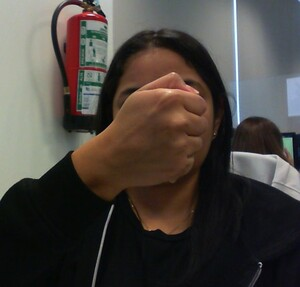

In [16]:
Image.open("a_ejemplo_res.jpg")

These are new RGB images with 300 x 300 size

In [ ]:
image_size = (300, 300)
# Loading images
img_resize = keras.preprocessing.image.load_img(
    "a_ejemplo_resize.jpg", target_size= image_size)
img2_resize = keras.preprocessing.image.load_img(
    "e_ejemplo_resize.jpg", target_size= image_size)
img3_resize = keras.preprocessing.image.load_img(
    "i_ejemplo_resize.jpg", target_size= image_size)
img4_resize = keras.preprocessing.image.load_img(
    "o_ejemplo_resize.jpg", target_size= image_size)
img5_resize = keras.preprocessing.image.load_img(
    "u_ejemplo_resize.jpg", target_size= image_size)

# Image to array
img_array_resize = image.img_to_array(img_resize)
img_batch_resize = np.expand_dims(img_array_resize, axis=0)

img_array2_resize = image.img_to_array(img2_resize)
img_batch2_resize = np.expand_dims(img_array2_resize, axis=0)

img_array3_resize = image.img_to_array(img3_resize)
img_batch3_resize = np.expand_dims(img_array3_resize, axis=0)

img_array4_resize = image.img_to_array(img4_resize)
img_batch4_resize = np.expand_dims(img_array4_resize, axis=0)

img_array5_resize = image.img_to_array(img5_resize)
img_batch5_resize = np.expand_dims(img_array5_resize, axis=0)

# Predictions
prediction_1_resize = best_model.predict(img_batch_resize)
prediction_2_resize = best_model.predict(img_batch2_resize)
prediction_3_resize = best_model.predict(img_batch3_resize)
prediction_4_resize = best_model.predict(img_batch4_resize)
prediction_5_resize = best_model.predict(img_batch5_resize)


1/1 [==============================] - 0s 22ms/step


In [ ]:
# Print predictions
print('prediction_1_resize', prediction_1_resize, 'index = ', np.argmax(prediction_1_resize))
print('prediction_2_resize', prediction_2_resize, 'index = ', np.argmax(prediction_2_resize))
print('prediction_3_resize', prediction_3_resize, 'index = ', np.argmax(prediction_3_resize))
print('prediction_4_resize', prediction_4_resize, 'index = ', np.argmax(prediction_4_resize))
print('prediction_5_resize', prediction_5_resize, 'index = ', np.argmax(prediction_5_resize))

prediction_1_resize [[2.5387726e-06 6.6098152e-04 3.5506058e-03 7.9031509e-01 2.0547077e-01]] index =  3
prediction_2_resize [[2.1734822e-06 2.2663095e-03 2.0064884e-03 7.0061690e-01 2.9510817e-01]] index =  3
prediction_3_resize [[5.0158616e-07 1.7074590e-04 1.6187958e-04 9.1379064e-01 8.5876249e-02]] index =  3
prediction_4_resize [[9.1689549e-07 3.0760269e-04 9.3255175e-04 9.1766280e-01 8.1096098e-02]] index =  3
prediction_5_resize [[1.82692901e-07 1.00801866e-04 1.54136796e-04 9.82072294e-01
  1.76724717e-02]] index =  3


Therefore, the previous images which corresponds to the vowels in order, has the wrong classification with vowel class 0 (a), except for the a vowel where the classification is correct.

## Inference on the test images

In [ ]:
image_size = (300, 300)
# Loading images
img_resize1 = keras.preprocessing.image.load_img(
    "a_test.jpg", target_size= image_size)
img2_resize1 = keras.preprocessing.image.load_img(
    "e_test.jpg", target_size= image_size)
img3_resize1 = keras.preprocessing.image.load_img(
    "i_test.jpg", target_size= image_size)
img4_resize1 = keras.preprocessing.image.load_img(
    "o_test.jpg", target_size= image_size)
img5_resize1 = keras.preprocessing.image.load_img(
    "u_test.jpg", target_size= image_size)

# Image to array
img_array_resize1 = image.img_to_array(img_resize1)
img_batch_resize1 = np.expand_dims(img_array_resize1, axis=0)

img_array2_resize1 = image.img_to_array(img2_resize1)
img_batch2_resize1 = np.expand_dims(img_array2_resize1, axis=0)

img_array3_resize1 = image.img_to_array(img3_resize1)
img_batch3_resize1 = np.expand_dims(img_array3_resize1, axis=0)

img_array4_resize1 = image.img_to_array(img4_resize1)
img_batch4_resize1 = np.expand_dims(img_array4_resize1, axis=0)

img_array5_resize1 = image.img_to_array(img5_resize1)
img_batch5_resize1 = np.expand_dims(img_array5_resize1, axis=0)

# Predictions
prediction_1_resize1 = best_model.predict(img_batch_resize1)
prediction_2_resize1 = best_model.predict(img_batch2_resize1)
prediction_3_resize1 = best_model.predict(img_batch3_resize1)
prediction_4_resize1 = best_model.predict(img_batch4_resize1)
prediction_5_resize1 = best_model.predict(img_batch5_resize1)


1/1 [==============================] - 0s 20ms/step


In [ ]:
# Print predictions
print('prediction_1_resize', prediction_1_resize1, 'index = ', np.argmax(prediction_1_resize1))
print('prediction_2_resize', prediction_2_resize1, 'index = ', np.argmax(prediction_2_resize1))
print('prediction_3_resize', prediction_3_resize1, 'index = ', np.argmax(prediction_3_resize1))
print('prediction_4_resize', prediction_4_resize1, 'index = ', np.argmax(prediction_4_resize1))
print('prediction_5_resize', prediction_5_resize1, 'index = ', np.argmax(prediction_5_resize1))

prediction_1_resize [[9.9920940e-01 6.0533075e-05 1.3327873e-07 6.1695114e-06 7.2378555e-04]] index =  0
prediction_2_resize [[2.4007866e-06 9.9999654e-01 3.6750166e-08 9.1320544e-07 1.3425318e-07]] index =  1
prediction_3_resize [[7.8686327e-03 4.4760486e-04 9.8874235e-01 2.8516350e-03 8.9711983e-05]] index =  2
prediction_4_resize [[2.7259438e-07 2.6625916e-05 8.4427911e-06 9.9050963e-01 9.4549926e-03]] index =  3
prediction_5_resize [[2.4755386e-06 3.5111825e-06 1.6887127e-05 2.7853134e-03 9.9719185e-01]] index =  4


We can see that on the test set, all the classifications are correct. Besides, these are plots to see the training process according the epochs

In [ ]:
def plot_training_curves(history, val=True):
    #Defining the metrics we will plot.
    train_acc=history.history['accuracy']  
    train_loss = history.history['loss']

    if val :
        val_acc=history.history['val_accuracy']
        val_loss = history.history['val_loss']

    #Range for the X axis.
    epochs = range(len(train_loss))

    fig,axis=plt.subplots(1,2,figsize=(20,8))#1 row, 2 col , width=20,height=8 inches.

    #Plotting Loss figures.
    plt.rcParams.update({'font.size': 22}) #configuring font size.
    plt.subplot(1,2,1) #plot 1st curve.
    plt.plot(epochs,train_loss,c="red",label="Training Loss") #plotting
    if val: plt.plot(epochs,val_loss,c="blue",label="Validation Loss")
    plt.xlabel("Epochs") #title for x axis
    plt.ylabel("Loss")   #title for y axis
    plt.legend()

    #Plotting Accuracy figures. 
    plt.subplot(1,2,2) #plot 2nd curve.
    plt.plot(epochs,train_acc,c="red",label="Training Acc") #plotting
    if val : plt.plot(epochs,val_acc,c="blue",label="Validation Acc")
    plt.xlabel("Epochs")   #title for x axis
    plt.ylabel("Accuracy") #title for y axis
    plt.legend()


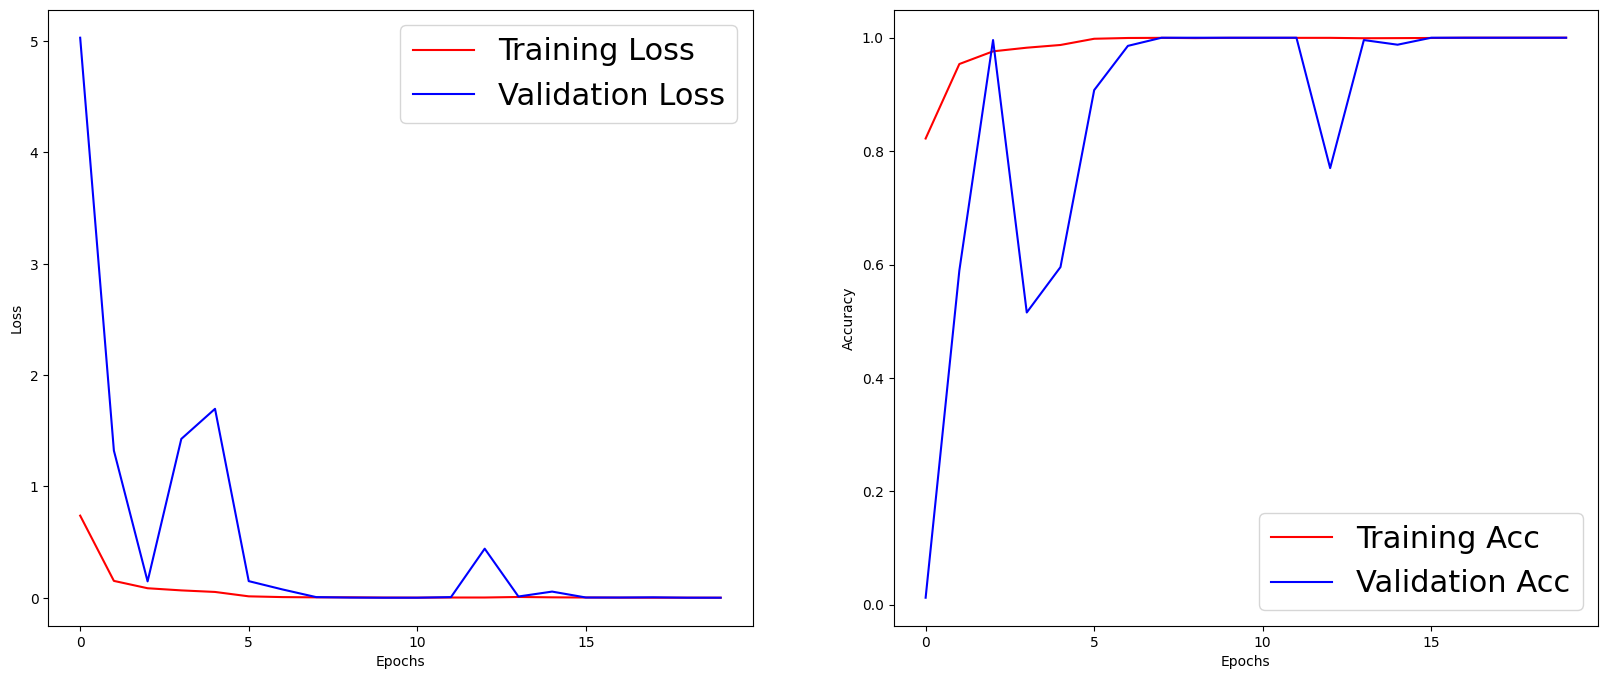

In [ ]:
plot_training_curves(hist, val=True)

Sources:

0. https://github.com/Poulinakis-Konstantinos/Blogging-Journey/blob/main/Keras-Tuner-Complete-Tutorial/keras-tuner.ipynb

1. https://pub.towardsai.net/keras-tuner-tutorial-hyperparameter-optimization-tensorflow-keras-computer-vision-example-c9abbdad9887

2. https://www.tensorflow.org/tutorials/keras/keras_tuner

3. [TensorBoard inside Colab](https://keras.io/guides/keras_tuner/visualize_tuning/) 

4. [Visualize the hyperparameter tuning process](https://keras.io/guides/keras_tuner/visualize_tuning/)

5. [Getting started with KerasTuner](https://keras.io/guides/keras_tuner/getting_started/)

6. [TensorBoard Tutorial in Keras for Beginner](https://machinelearningknowledge.ai/tensorboard-tutorial-in-keras-for-beginner/)

7. [Keras tuner github example](https://github.com/keras-team/keras-tuner)